In [1]:
# Scientific computing and data manipulation
import math
import time
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp

# Visualization
import matplotlib.pyplot as plt

# Machine learning and deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, LeaveOneOut

# Hyperparameter optimization
import optuna

# LTC Model
from ncps.wirings import AutoNCP
from ncps.torch import LTC, CfC

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EarlyStopping function

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

In [4]:
#import random

# To fix the random seed
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)
#random.seed(seed)

# Ensure deterministic behavior in PyTorch
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# DEFINE PARAMETERS

In [5]:
# define constant parameters

R = (6.4*10e-3)/2 # Tubular radius, units: m
qp_480 = 1.3 * 10e-4 * 60 # Photon flux, units: moles photons · m-2 · min-1
Vr = 4.78 * 10e-6# Reactor volume, units: m3
CB = 0.4 # Concentartion of reactant B, units: M

# Calculate photon flux at different power ratings

# 240 W
qp_240 = qp_480*240/480

#120 W
qp_120 = qp_480*120/480

In [6]:
# Experimentally measured parameters

phi_n = 0.07508614 # Quantum yield, units: mole/Einstien
k1 = 0.01953897 # rate constant for formation of species C
k2 = 0.11706072 # rate constant for formation of species E

# Regressed parameters

mpc = 94.6*0.02*(1/1000) # photon absorption by photocatalyst
ka =  324.7*(1/1000) # Napierian molar absorption coefficient of specis A, units: m2/mol
kc = 345.5*(1/1000) # Napierian molar absorption coefficient of specis C, units: m2/mol 

# LOAD DATA

In [7]:
Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0
    #Input_list.append([X[0,0],X[0,1]])
    
X1 = [round(X1[i], 2) for i in range(len(X1))]

Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


# DEFINE RNN

In [8]:
class RNN(nn.Module):
    "Defines a RNN network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS
        
        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN[0], 
                                batch_first=True)
            
            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i], 
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )
            
            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)
            
            self.list_flag = True
            
        else:
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)
            
            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
            
            self.list_flag = False                                             
        
    def forward(self, x):
        x, _ = self.rnn(x)
        
        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)
                
        x = self.output_layer(x)
        return x

# GENERATE DATA FOR SOURCE MODEL

In [9]:
# Generating time steps at which the output must be recorded
X1_ = list()
for i in X1:
    X1_.append(round(i, 2))
X1_ = np.array(X1_)

In [10]:
def CSimulation(CAo,qp): 
    
    CAo = CAo*1000
    qp = qp*60
    CA = 1
    CC = 0
    CE = 0
    CB = 0.4*1000
    
    CA_list = list()
    CC_list = list()
    CE_list = list()
    
    t_step = 0.01
    
    for i in range(2200):
        dCAndtau = -((phi_n/CAo)*(qp/Vr)*(ka*CA*CAo/(mpc+ka*CA*CAo+kc*CC*CAo))
                     *(1-np.exp(-(mpc+ka*CA*CAo+kc*CC*CAo)*2*R)))
        
        dCCndtau = ((k1*CB)/(k1*CB+k2)**1)*((phi_n/CAo)*(qp/Vr)*(ka*CA*CAo/(mpc+ka*CA*CAo+kc*CC*CAo))
                                            *(1-np.exp(-(mpc+ka*CA*CAo+kc*CC*CAo)*2*R)))**1  
        
        dCEndtau = (k2/(k1*CB+k2)**1)*((phi_n/CAo)*(qp/Vr)*(ka*CA*CAo/(mpc+ka*CA*CAo+kc*CC*CAo))
                                       *(1-np.exp(-(mpc+ka*CA*CAo+kc*CC*CAo)*2*R)))**1  
     
        CA += dCAndtau * t_step
        CC += dCCndtau * t_step
        CE += dCEndtau * t_step
        if round(i*t_step, 2) in X1_:
            CA_list.append(CA) 
            CC_list.append(CC)  
            CE_list.append(CE)  
        

    return [CA_list,CC_list,CE_list]

In [11]:
# Test 1 full stability region

CAo_list = np.linspace(10, 50, 50, endpoint=True)/10  # mol/m3
qp_list = np.linspace(325, 325*5, 50, endpoint=True)/1e6 # min
print(CAo_list)
print(qp_list)

CA_output = list()
CC_output = list()
CE_output = list()

CAo_input = list()
qp_input = list()
CA_input = list()
CC_input = list()
CE_input = list()

for CAo in CAo_list:   
    for qp in qp_list:
        CAo_input.append(CAo)
        qp_input.append(qp)
        CA_input.append(1.0)
        CC_input.append(0.0)
        CE_input.append(0.0)
            
        CA_list,CC_list,CE_list = CSimulation(CAo,qp)
        CA_output.append(CA_list)
        CC_output.append(CC_list)
        CE_output.append(CE_list)

[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]
[0.000325   0.00035153 0.00037806 0.00040459 0.00043112 0.00045765
 0.00048418 0.00051071 0.00053724 0.00056378 0.00059031 0.00061684
 0.00064337 0.0006699  0.00069643 0.00072296 0.00074949 0.00077602
 0.00080255 0.00082908 0.00085561 0.00088214 0.00090867 0.0009352
 0.00096173 0.00098827 0.0010148  0.00104133 0.00106786 0.00109439
 0.00112092 0.00114745 0.00117398 0.00120051 0.00122704 0.00125357
 0.0012801  0.00130663 0.00133316 0.0013

In [12]:
# collate input for RNN

CAo_input = np.array(CAo_input).reshape(-1,1,1)
qp_input = np.array(qp_input).reshape(-1,1,1)

CA_input = np.array(CA_input).reshape(-1,1,1)
CC_input = np.array(CC_input).reshape(-1,1,1)
CE_input = np.array(CE_input).reshape(-1,1,1)

RNN_input = np.concatenate((CAo_input, qp_input, CA_input, CC_input, CE_input), axis=2)   #the value for input variable and the initial value for state variable 

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""
RNN_input = RNN_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output, since the output variable is collected 100(0.01/1e-4) times for each RNN_input
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (2500, 36, 5)


In [13]:
CA_output = np.array(CA_output).reshape(-1, 36, 1)
CC_output = np.array(CC_output).reshape(-1, 36, 1)
CE_output = np.array(CE_output).reshape(-1, 36, 1)
RNN_output = np.concatenate((CA_output, CC_output, CE_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (2500, 36, 3)


In [14]:
# split into train and test sets
X_train, X_test, Y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=123)

# Splitting validation set

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(x_train.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 3))


x_train = scaler_X.transform(x_train.reshape(-1, 5)).reshape(-1,36, 5)
x_test = scaler_X.transform(X_test.reshape(-1, 5)).reshape(-1,36, 5)
x_val = scaler_X.transform(x_val.reshape(-1, 5)).reshape(-1,36, 5)
y_train = scaler_y.transform(y_train.reshape(-1,3)).reshape(-1,36, 3)
y_test = scaler_y.transform(y_test.reshape(-1,3)).reshape(-1,36, 3)
y_val = scaler_y.transform(y_val.reshape(-1,3)).reshape(-1,36, 3)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1500, 36, 5) (500, 36, 5) (500, 36, 5) (1500, 36, 3) (500, 36, 3) (500, 36, 3)


In [15]:
# Load Data

x_train = torch.from_numpy(x_train).float()
x_val = torch.from_numpy(x_val).float()
x_test = torch.from_numpy(x_test).float()

y_train = torch.from_numpy(y_train).float()
y_val = torch.from_numpy(y_val).float()
y_test = torch.from_numpy(y_test).float()

dataset_physics_train = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset_physics_train, batch_size=10800, shuffle=True)

dataset_physics_val = TensorDataset(x_val, y_val)
val_loader = DataLoader(dataset_physics_val, batch_size=10800, shuffle=True)

dataset_physics_test = TensorDataset(x_test, y_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

In [16]:
def train_model_piltc(model, patience, n_epochs, lr):
    
    train_losses, valid_losses = [], []
    avg_train_losses, avg_valid_losses = [], []
    y_scaled_error = []
 
    optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=1e-5) # Adam optimizer
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch[0].to(device), y_batch[0].to(device)
            optimizer.zero_grad()

            NN_outputd = model(x_batch)
            NN_outputd = NN_outputd[0]
            loss1 = torch.mean((NN_outputd - y_batch) ** 2)
            
            loss = loss1 
            loss.backward()
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())
      
        # Validation
        model.eval()
        for x_valbatch, y_valbatch in val_loader:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            NN_outputv = model(x_valbatch)
            NN_outputv = NN_outputv[0]
            loss = torch.mean((NN_outputv - y_valbatch) ** 2)

            valid_losses.append(loss.item())
        
        # Logging
        train_loss = np.mean(train_losses)
        valid_loss = np.mean(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f"[{epoch}/{n_epochs}] train_loss: {train_loss:.5f} valid_loss: {valid_loss:.5f}")

        train_losses, valid_losses = [], []
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Evaluate best model on validation set once
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()

    final_predictions = []
    final_targets = []
    
    with torch.no_grad():
        for x_valbatch, y_valbatch in dataloader_physics_test:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            output = model(x_valbatch)
            output = output[0]

            preds = scaler_y.inverse_transform(output.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)
            targets = scaler_y.inverse_transform(y_valbatch.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)

            # Compute scaled loss
            c1 = np.sum(np.abs(preds[-1, :, 0] - targets[-1, :, 0]))
            c2 = np.sum(np.abs(preds[-1, :, 1] - targets[-1, :, 1]))
            c3 = np.sum(np.abs(preds[-1, :, 2] - targets[-1, :, 2]))
            scaled_loss = (3.377069851 * c1 + 1.443964636 * c2 + 88.12458286 * c3) / 100

            y_scaled_error.append(scaled_loss)

            final_predictions.append(preds)
            final_targets.append(targets)

    final_predictions = np.concatenate(final_predictions, axis=0)
    final_targets = np.concatenate(final_targets, axis=0)

    return model, avg_train_losses, avg_valid_losses, np.mean(avg_valid_losses), y_scaled_error, final_predictions, final_targets


In [17]:
out_features = 3
in_features = 5

wiring = AutoNCP(64, out_features)

piltc_model1 = LTC(in_features, wiring, batch_first=True)

n_epochs = 1000
patience = 200
lr = 0.01

piltc_trained1, train_loss, valid_loss, test_error, mean_scaled, predictions, targets = train_model_piltc(piltc_model1, patience, n_epochs, lr)

[1/1000] train_loss: 1.26934 valid_loss: 0.53710
Validation loss decreased (inf --> 0.537096).  Saving model ...
[2/1000] train_loss: 0.66226 valid_loss: 1.27389
EarlyStopping counter: 1 out of 200
[3/1000] train_loss: 2.77750 valid_loss: 0.76722
EarlyStopping counter: 2 out of 200
[4/1000] train_loss: 0.54094 valid_loss: 0.76471
EarlyStopping counter: 3 out of 200
[5/1000] train_loss: 1.29308 valid_loss: 0.78965
EarlyStopping counter: 4 out of 200
[6/1000] train_loss: 0.94660 valid_loss: 0.67578
EarlyStopping counter: 5 out of 200
[7/1000] train_loss: 0.80948 valid_loss: 0.58206
EarlyStopping counter: 6 out of 200
[8/1000] train_loss: 1.51334 valid_loss: 1.82575
EarlyStopping counter: 7 out of 200
[9/1000] train_loss: 0.97209 valid_loss: 2.19081
EarlyStopping counter: 8 out of 200
[10/1000] train_loss: 1.90228 valid_loss: 2.88865
EarlyStopping counter: 9 out of 200
[11/1000] train_loss: 0.99390 valid_loss: 0.77353
EarlyStopping counter: 10 out of 200
[12/1000] train_loss: 0.55018 vali

In [18]:
torch.save(piltc_trained1,'LTC.pkl')

# LOAD DATA FOR TARGET DOMAIN

In [19]:
# Experimental data to tune the Transfer Learning Model

Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0

Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


In [20]:
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output, since the output variable is collected 100(0.01/1e-4) times for each RNN_input
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (9, 36, 5)


In [21]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, 36, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, 36, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, 36, 1)
RNN_output = np.concatenate((Y1_output, Y2_output, Y3_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (9, 36, 3)


In [22]:
# split into train and test sets
x_train = RNN_input[:7,:,:]
x_test  = RNN_input[7:,:,:]

y_train = RNN_output[:7,:,:]
y_test =  RNN_output[7:,:,:]

In [23]:
# Normalization

scaler_X = preprocessing.StandardScaler().fit(x_train.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 3))

print(scaler_X.mean_)
print(scaler_X.var_)
print(scaler_y.mean_)
print(scaler_y.var_)

x_train = scaler_X.transform(x_train.reshape(-1, 5)).reshape(-1,36, 5)
x_test = scaler_X.transform(x_test.reshape(-1, 5)).reshape(-1,36, 5)
y_train = scaler_y.transform(y_train.reshape(-1,3)).reshape(-1,36, 3)
y_test = scaler_y.transform(y_test.reshape(-1,3)).reshape(-1,36, 3)

mean_y = torch.from_numpy(scaler_y.mean_).float()
std_y = torch.from_numpy(np.sqrt(scaler_y.var_)).float()

[2.71428571e-01 3.08571429e+02 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[4.89795918e-03 2.40979592e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.27897316 0.70880471 0.01222213]
[2.25483977e-02 2.15162303e-02 1.75404646e-05]


In [24]:
import joblib

# Save the fitted scaler
joblib.dump(scaler_X, 'scaler_X')
joblib.dump(scaler_y, 'scaler_y')

['scaler_y']

In [25]:
############################# Split Train, Test, and Validation dataset ##################################

#X_train, x_test, Y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=42)

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train shape is {x_train.shape}, X_test shape is {x_test.shape}")
print(f"y_train shape is {y_train.shape}, y_test shape is {y_test.shape}")

X_train shape is (7, 36, 5), X_test shape is (2, 36, 5)
y_train shape is (7, 36, 3), y_test shape is (2, 36, 3)


In [26]:
# Transform Data

x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [27]:
dataset_physics_test = TensorDataset(x_test, y_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

In [28]:
"""
Test Source model on the 2 test datapoints
"""
piltc_trained1 = torch.load('LTC.pkl')
piltc_trained1.to(device)
print(piltc_trained1)

y_test_error = list()
piltc_trained1.eval()
for id_batch, (x_batch, y_batch) in enumerate(dataloader_physics_test):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    NN_output = piltc_trained1(x_batch)
    NN_out = NN_output[0]
    MSE_loss= torch.mean((NN_out - y_batch)**2)
    y_test_error.append(MSE_loss.item())

print(f"mean error is {np.mean(y_test_error)}, std is {np.std(y_test_error)}") 

LTC(
  (rnn_cell): LTCCell(
    (make_positive_fn): Softplus(beta=1.0, threshold=20.0)
    (_clip): ReLU()
  )
)
mean error is 0.5004966408014297, std is 0.0260612815618515


In [29]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

# create loocv procedure
cv = LeaveOneOut()
batch_size = 32
k = 7

In [30]:
y_glob = []  # Will be a list of lists: shape (n_folds, n_repeats_per_fold)
sc_y_glob = []

all_val_preds = []  # list of length n_folds, each item is (5, n_samples, 36, 3)
val_targets = None


for fold, (train_idx_A, val_idx_A) in enumerate(cv.split(x_train)):
    print(f"  Fold {fold + 1}/{k}")

    # Create TensorDatasets and DataLoaders
    train_datasetA = TensorDataset(x_train[train_idx_A], y_train[train_idx_A])
    val_datasetA = TensorDataset(x_train[val_idx_A], y_train[val_idx_A])
    train_loader = DataLoader(train_datasetA, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_datasetA, batch_size=batch_size, shuffle=False)

    fold_errors = []
    sc_fold_errors = []

    for i in range(5):  # Repeat training to observe variability
        
        source_TL = torch.load('LTC.pkl')
        source_TL.to(device)

        print(f"  Training {i+1}/5 for Fold {fold+1}")
        #print(model_PINN)

        n_epochs = 100
        patience = 100
        lr = 0.01

        model_PINN, train_loss, valid_loss, test_error, mean_scaled, predictions, targets = train_model_piltc(
            source_TL, patience, n_epochs, lr)

        fold_errors.append(test_error)
        sc_fold_errors.append(mean_scaled)
        
        if i == 0:
            val_preds_fold = [predictions]
        else:
            val_preds_fold.append(predictions)

    y_glob.append(fold_errors) # Mean Squared Errors
    sc_y_glob.append(sc_fold_errors) # Scaled Average Errors
    
    val_preds_fold = np.stack(val_preds_fold, axis=0)  # shape: (5, n_samples, 36, 3)
    all_val_preds.append(val_preds_fold)

    if fold == 0:  # Only store ground truth once
        val_targets = targets

# Convert to NumPy array for easier processing
y_glob = np.array(y_glob)  # shape: (n_folds, 5)
sc_y_glob = np.array(sc_y_glob)  # shape: (n_folds, 5)

  Fold 1/7
  Training 1/5 for Fold 1
[1/100] train_loss: 0.38070 valid_loss: 1.10860
Validation loss decreased (inf --> 1.108604).  Saving model ...
[2/100] train_loss: 0.70896 valid_loss: 0.82277
Validation loss decreased (1.108604 --> 0.822773).  Saving model ...
[3/100] train_loss: 0.41624 valid_loss: 0.69329
Validation loss decreased (0.822773 --> 0.693287).  Saving model ...
[4/100] train_loss: 0.35647 valid_loss: 0.57448
Validation loss decreased (0.693287 --> 0.574482).  Saving model ...
[5/100] train_loss: 0.29669 valid_loss: 0.51278
Validation loss decreased (0.574482 --> 0.512781).  Saving model ...
[6/100] train_loss: 0.51733 valid_loss: 0.48123
Validation loss decreased (0.512781 --> 0.481232).  Saving model ...
[7/100] train_loss: 0.49187 valid_loss: 0.45304
Validation loss decreased (0.481232 --> 0.453043).  Saving model ...
[8/100] train_loss: 0.33629 valid_loss: 0.43363
Validation loss decreased (0.453043 --> 0.433633).  Saving model ...
[9/100] train_loss: 0.29686 vali

In [31]:
print(y_glob.shape)
print(sc_y_glob.shape)

(7, 5)
(7, 5, 2)



=== Summary for Output 1 ===
Per-Fold Means: [0.07251388 0.04159868 0.05391242 0.05629694 0.04392656 0.05924052
 0.0923921 ]
Per-Fold Std Devs: [0.01384693 0.00350301 0.00567541 0.00388084 0.00332346 0.009933
 0.01706828]
Overall Mean: 0.0600, Overall Std: 0.0189


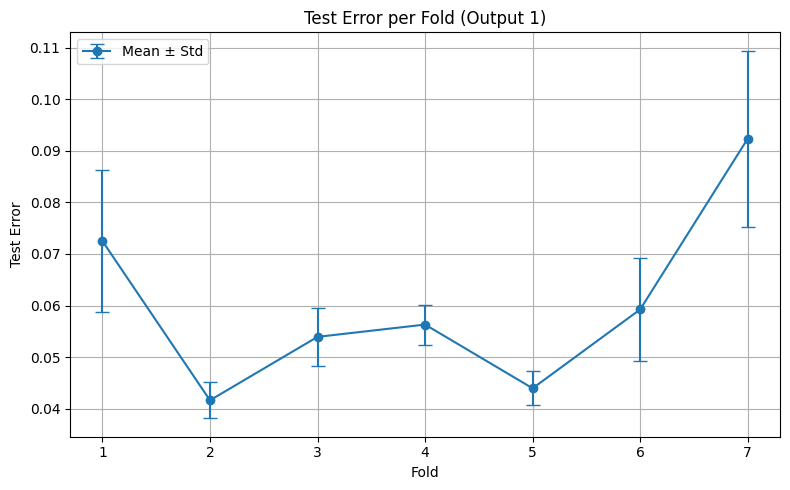


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.061211  0.060989  0.060246  0.058651  0.058819   0.059983  0.008176
std    0.021720  0.025193  0.021138  0.016405  0.016115   0.017579  0.005544
min    0.039936  0.042484  0.036333  0.042188  0.037555   0.041599  0.003323
25%    0.048933  0.045791  0.047480  0.048502  0.049709   0.048919  0.003692
50%    0.055758  0.047218  0.057058  0.052084  0.060267   0.056297  0.005675
75%    0.064891  0.069292  0.067183  0.064389  0.062918   0.065877  0.011890
max    0.105134  0.107054  0.099003  0.090503  0.088653   0.092392  0.017068

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.072514  0.013847
1   0.041599  0.003503
2   0.053912  0.005675
3   0.056297  0.003881
4   0.043927  0.003323
5   0.059241  0.009933
6   0.092392  0.017068

Per-fold Summary (across runs):
         Fold_1    F

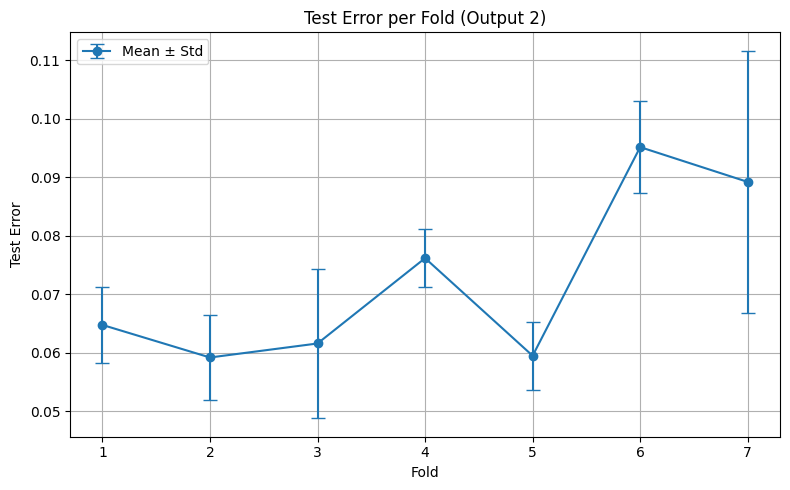


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.068703  0.079289  0.073909  0.073235  0.065861   0.072199  0.009666
std    0.015673  0.025929  0.018739  0.017177  0.012586   0.014906  0.006181
min    0.045457  0.053343  0.051812  0.052150  0.052071   0.059157  0.004975
25%    0.059344  0.063257  0.057217  0.060678  0.056561   0.060504  0.006173
50%    0.070342  0.071689  0.077780  0.067875  0.064673   0.064727  0.007238
75%    0.079286  0.089938  0.087486  0.087098  0.072185   0.082675  0.010327
max    0.087861  0.123604  0.098362  0.097068  0.086790   0.095153  0.022451

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.064727  0.006548
1   0.059157  0.007238
2   0.061554  0.012809
3   0.076154  0.004975
4   0.059455  0.005798
5   0.095153  0.007844
6   0.089197  0.022451

Per-fold Summary (across runs):
         Fold_1    F

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume sc_y_glob shape is (7, 5, 2) => (folds, runs, outputs)
n_outputs = sc_y_glob.shape[2]

for i in range(n_outputs):
    print(f"\n=== Summary for Output {i+1} ===")
    
    data_i = sc_y_glob[:, :, i]  # shape: (7, 5)
    
    fold_means = np.mean(data_i, axis=1)
    fold_stds = np.std(data_i, axis=1)

    overall_mean = np.mean(data_i)
    overall_std = np.std(data_i)

    # Print summary
    print("Per-Fold Means:", fold_means)
    print("Per-Fold Std Devs:", fold_stds)
    print(f"Overall Mean: {overall_mean:.4f}, Overall Std: {overall_std:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.errorbar(range(1, len(fold_means)+1), fold_means, yerr=fold_stds, fmt='o-', capsize=5, label='Mean ± Std')
    plt.title(f'Test Error per Fold (Output {i+1})')
    plt.xlabel('Fold')
    plt.ylabel('Test Error')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # DataFrame Summary
    df_results = pd.DataFrame(data_i, columns=[f"Run_{j+1}" for j in range(data_i.shape[1])])
    df_results["Fold_Mean"] = df_results.mean(axis=1)
    df_results["Fold_Std"] = df_results.std(axis=1)

    print("\nSummary Statistics (per training run):")
    print(df_results.describe())

    print("\nPer-fold Means and Std Devs:")
    print(df_results[["Fold_Mean", "Fold_Std"]])

    df_fold_view = df_results.drop(columns=["Fold_Mean", "Fold_Std"]).T
    df_fold_view.columns = [f"Fold_{k+1}" for k in range(df_fold_view.shape[1])]

    print("\nPer-fold Summary (across runs):")
    print(df_fold_view.describe())

C:\Users\vkeerth\AppData\Local\Temp\ipykernel_10400\2927859257.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc='best')


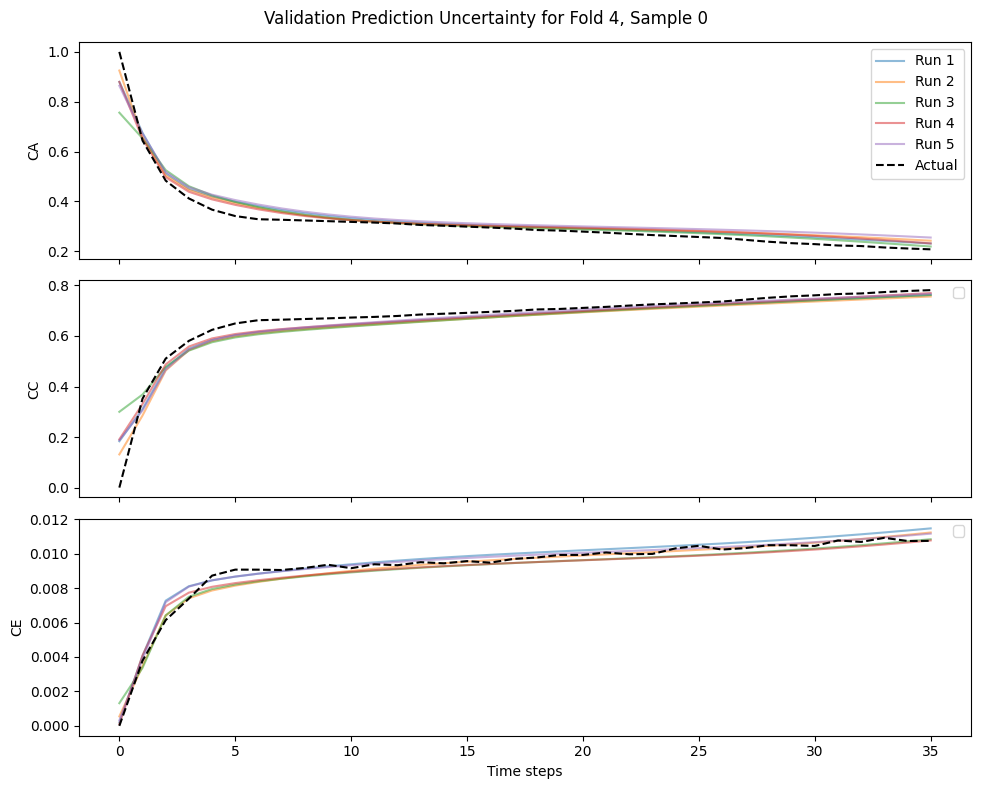

In [33]:
import matplotlib.pyplot as plt

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

time = np.arange(36)  # time steps

for i, label in enumerate(['CA', 'CC', 'CE']):
    for run in range(5):
        axs[i].plot(time, all_val_preds[fold_idx][run, sample_idx, :, i], alpha=0.5, label=f'Run {run+1}' if i==0 else None)

    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', label='Actual' if i==0 else None)
    axs[i].set_ylabel(label)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Time steps")
plt.suptitle(f"Validation Prediction Uncertainty for Fold {fold_idx+1}, Sample {sample_idx}")
plt.tight_layout()
plt.show()

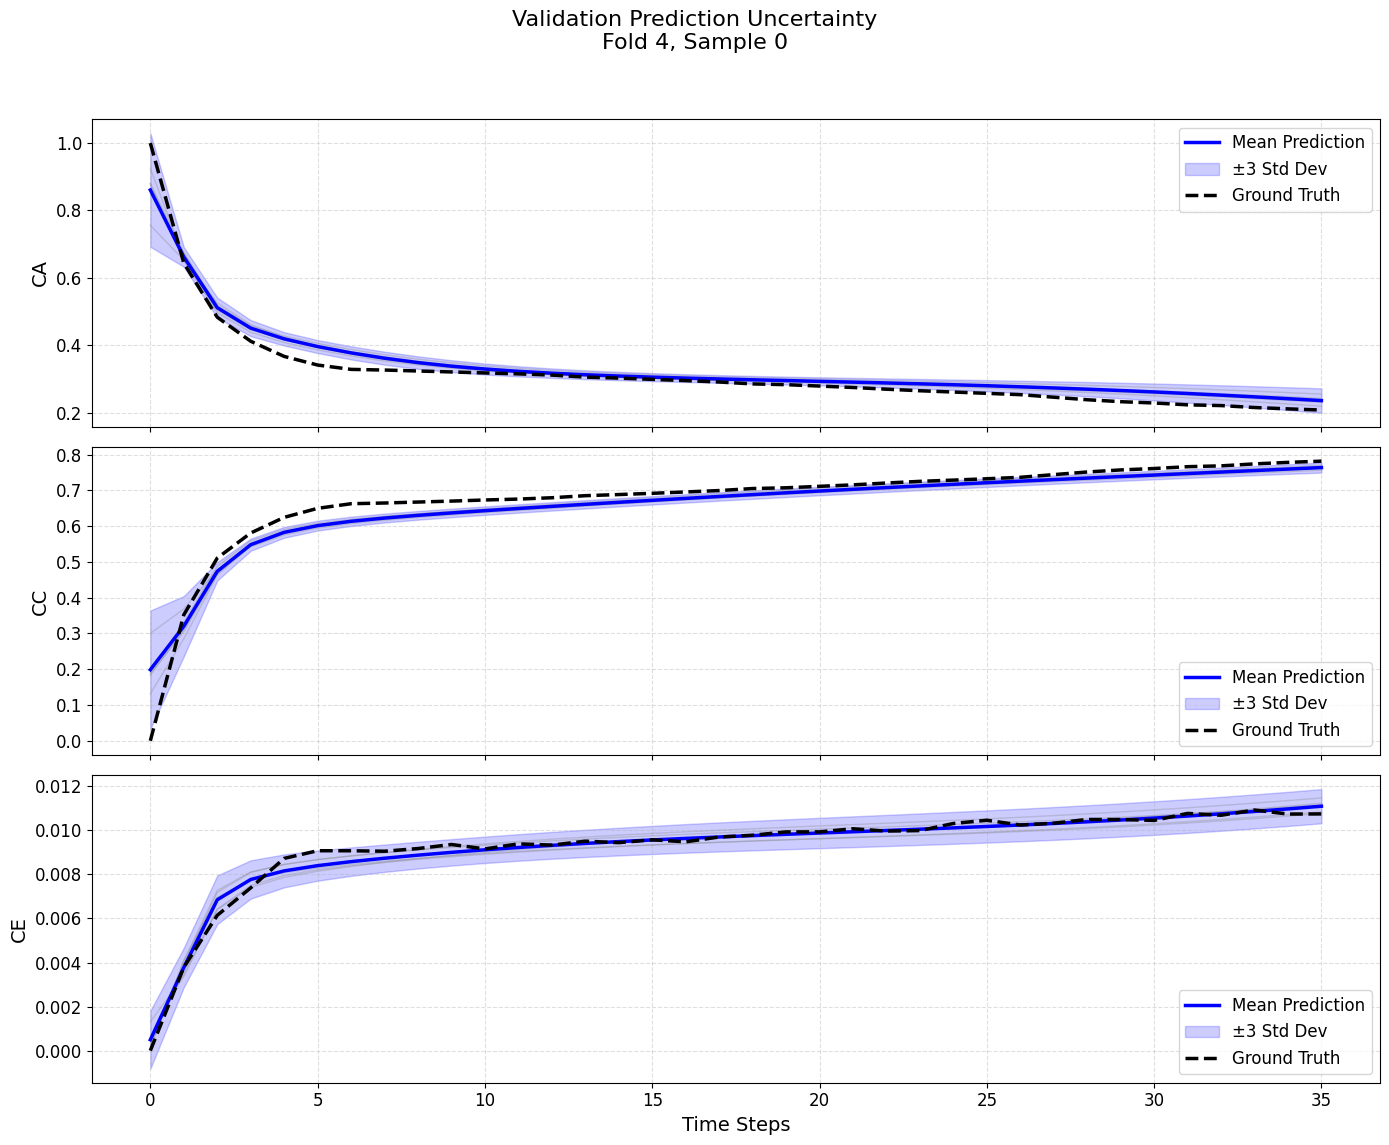

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set
time = np.arange(36)  # time steps
labels = ['CA', 'CC', 'CE']

n_runs = len(all_val_preds[fold_idx])

# Bigger figure and fonts
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, label in enumerate(labels):
    runs = np.array([all_val_preds[fold_idx][run, sample_idx, :, i] for run in range(n_runs)])
    mean_pred = runs.mean(axis=0)
    std_pred = runs.std(axis=0)

    # Light individual runs
    for run in range(n_runs):
        axs[i].plot(time, runs[run], color='gray', alpha=0.3, linewidth=1)

    # Mean and uncertainty
    axs[i].plot(time, mean_pred, color='blue', linewidth=2.5, label='Mean Prediction')
    axs[i].fill_between(time, mean_pred - 3*std_pred, mean_pred + 3*std_pred, 
                        color='blue', alpha=0.2, label='±3 Std Dev')

    # Ground truth
    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', linewidth=2.5, label='Ground Truth')

    axs[i].set_ylabel(label, fontsize=14)
    axs[i].legend(loc='best', fontsize=12)
    axs[i].tick_params(labelsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.4)

axs[-1].set_xlabel("Time Steps", fontsize=14)
plt.suptitle(f"Validation Prediction Uncertainty\nFold {fold_idx + 1}, Sample {sample_idx}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()